# Python in genomic analysis - a case study

1. Read the paper (Optional if you are looking at your own data)
2. Formulate the question
3. Find the data
4. Obtain, process
5. Analyze!

## Paper: Hormone-Responsive Enhancer-Activity Maps Reveal Predictive Motifs, Indirect Repression, and Targeting of Closed Chromatin

### Questions: 
1. Where are the ecdysone-induced enhancers in chromosome 3L?
2. What transcription factors may bind at these enhancers?




### How to get the data?

#### This happens behind the scenes for this class to save time, but I wanted to share the whole process so you are aware of how you could do this by yourself.

1. Get the "reads" as fastq files<br><br>
`
fastq-dump SRR1204764
fastq-dump SRR1204762
`
<br><br>
2. Align the reads to the genome<br><br>
`
bowtie2 -x /beevol/home/srinivas/lib/bowtie2/dm6/genome -q SRR1204764.fastq --no-unal -p 10 >  w_ecd.sam
bowtie2 -x /beevol/home/srinivas/lib/bowtie2/dm6/genome -q SRR1204762.fastq --no-unal -p 10 >  wo_ecd.sam
`
<br><br>
3. Convert the sam to bam (binary compressed format that will be read by bedtools)<br><br>
`
samtools view -Sb w_ecd.sam > w_ecd.bam
samtools view -Sb wo_ecd.sam > wo_ecd.bam
`
<br><br>

4. Convert bam to bed (bed file will have one read per line, a human readable form)<br><br>
`
bedtools bamtobed -i w_ecd.bam > w_ecd.bed
bedtools bamtobed -i wo_ecd.bam > wo_ecd.bed
`
<br><br>

5. Convert bed to wig (we collapse the reads into a wig file)<br><br>

`123456789`<br>
`----_____`<br>
`___----__`<br>
`_____----`<br>
`______---`<br>
`______---`<br>
`111212433`<br>

In [ ]:
def readwig (inFile):
  wig=open(inFile, 'r' )
  val={}
  for line in wig:
    lineL = line.split()
    if "chr" in lineL[1]:
      cj=lineL[1]
      chrom=cj[9:]
      print(chrom)
      val.setdefault(chrom,{})
    elif "rack" not in line:
      pos=int(lineL[0])
      val[chrom][pos] = float(lineL[1])
  return(val)

In [212]:
w_ecd = readwig('3L.w_ecd.wig')
wo_ecd = readwig('3L.wo_ecd.wig')

3L
3L


In [213]:
import numpy as np
subset_w_ecd = []
for i in range(17950953-30000,17950953+30000):
    if i in w_ecd['3L']:
        subset_w_ecd.append(w_ecd['3L'][i])
ns_w_ecd = np.array(subset_w_ecd)

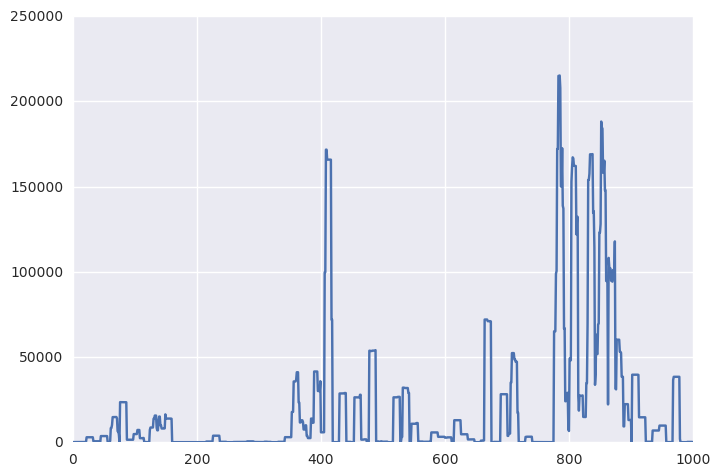

In [214]:
import matplotlib.pyplot as plt

plt.plot(ns_w_ecd)
plt.show()

In [215]:
import scipy
from scipy.signal import find_peaks
from numpy import pi

x = np.linspace( 0, 6*pi, 600 )
f = np.sin(x)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

peaks, _ = find_peaks(f, height=0)

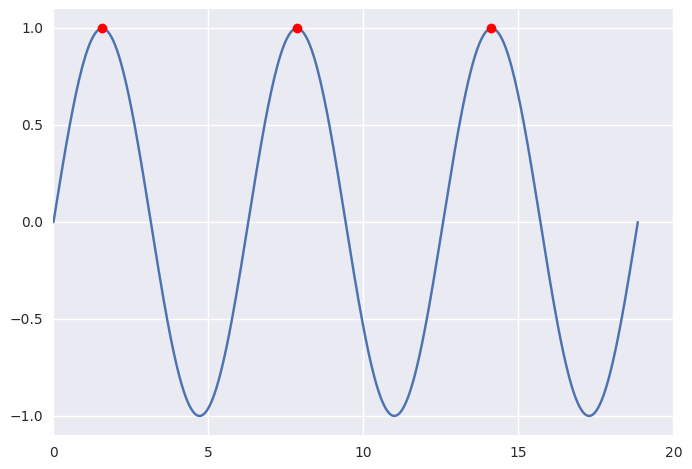

In [216]:
plt.plot(x,f)
plt.plot(x[peaks], f[peaks], "ro")
plt.ylim(-1.1,1.1)
plt.show()

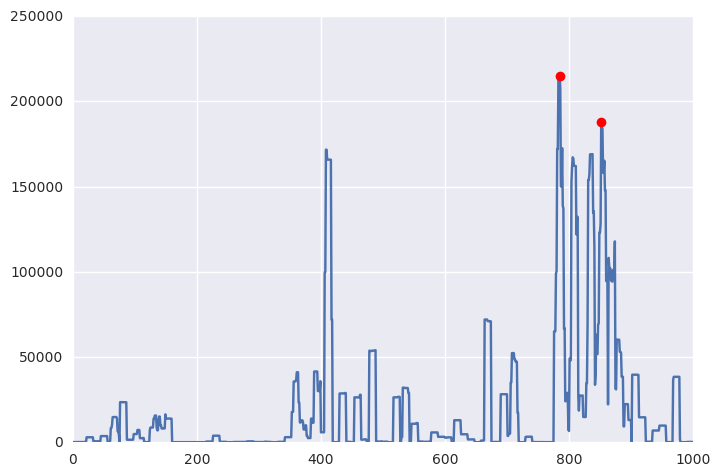

In [221]:
indices = np.arange(0,len(ns_w_ecd))
#peaks, _ = find_peaks(ns_w_ecd) 
#peaks, _ = find_peaks(ns_w_ecd, height=ns_w_ecd.mean()) 
#peaks, _ = find_peaks(ns_w_ecd, height=ns_w_ecd.mean(),distance=10) 
peaks, _ = find_peaks(ns_w_ecd, height=4*ns_w_ecd.std()+ns_w_ecd.mean())
#our unit is 10 bp, so distance of 10 is highest peak within 100 bp
plt.plot(ns_w_ecd)
plt.plot(indices[peaks],ns_w_ecd[peaks], "ro")
plt.show()

//anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


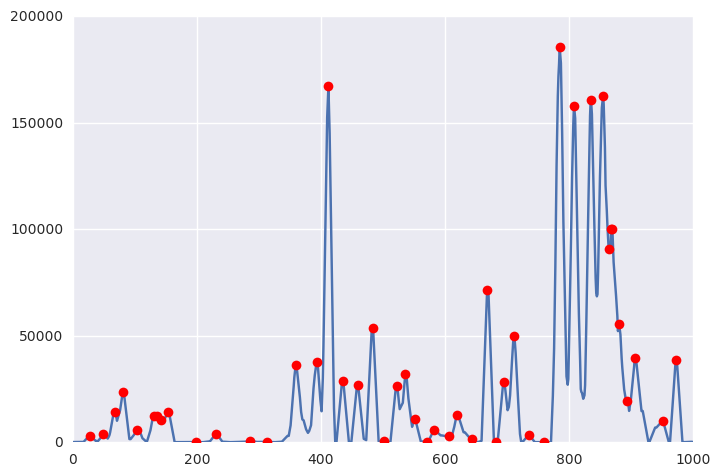

In [223]:
#Too rough so many local maxima. Let us try to smooth this distribution. We will use Savitsky Golay filter.
# https://en.wikipedia.org/wiki/Savitzky%E2%80%93Golay_filter
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html
from scipy.signal import savgol_filter
smooth_ar = savgol_filter(ns_w_ecd,9,1)
#peaks, _ = find_peaks(smooth_ar, height=3*smooth_ar.std()+smooth_ar.mean(), distance=10)
peaks, _ = find_peaks(smooth_ar)
#plt.plot(ns_w_ecd)
plt.plot(smooth_ar,)
plt.plot(indices[peaks],smooth_ar[peaks], "ro")
plt.show()

In [224]:
#let us apply this to the whole chromosome

temp_list = [] #Values
pos_list = [] #Chromosome positions

for i in sorted(w_ecd['3L'].keys()):
    temp_list.append(w_ecd['3L'][i])
    pos_list.append(i)

chrom_array = np.array(temp_list)

smooth_ar = savgol_filter(chrom_array,9,1)
peaks_ecd, _ = find_peaks(smooth_ar, height=4*smooth_ar.std()+smooth_ar.mean(), distance=10)
len(peaks_ecd)

//anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


202

In [225]:
#Now for the non ecdysone treated sample

temp_list = []
pos_list_wo = []

for i in sorted(wo_ecd['3L'].keys()):
    temp_list.append(wo_ecd['3L'][i])
    pos_list_wo.append(i)

chrom_array_wo = np.array(temp_list)

smooth_ar_wo = savgol_filter(chrom_array_wo,9,1)
peaks_wo_ecd, _ = find_peaks(smooth_ar_wo, height=4*smooth_ar_wo.std()+smooth_ar_wo.mean(), distance=10)
len(peaks_wo_ecd)

//anaconda/lib/python3.5/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


367

#### Do the peaks make sense?

1. Let us first understand how to trace back the genomic location from the peak<br><br>

`Indices  :  0  1  2  3  4  5  6  7  8`<br>
`Positions: 22 23 24 25 26 27 28 29 30`<br>
`maxima   :           *        *      `<br><br>
`peak_list : 3,6`<br><br>
`peak_list[0] = 3`<br><br>
`positions[peak_list[0]] = 25`
<br><br>Now we can ask if the signal around the peak position is high.


In [228]:
#Spit out a random peak

rand_index = int(np.random.rand()*len(peaks_ecd)-1)
print(rand_index)
print(peaks_ecd[rand_index])
peak_val = pos_list[peaks_ecd[rand_index]]
print(peak_val)

83
92069
10187840


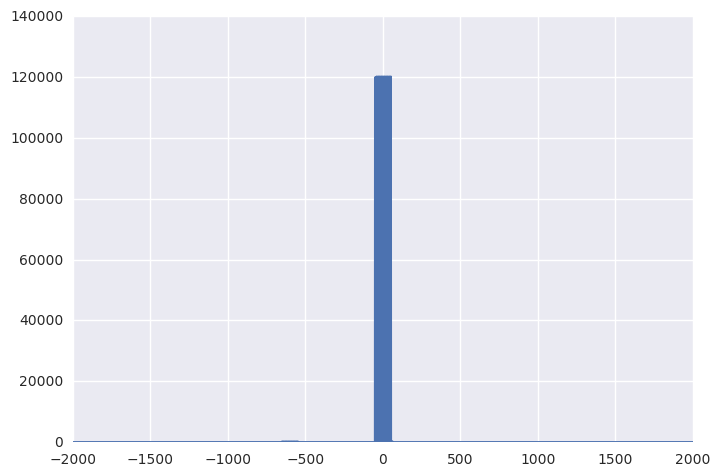

In [229]:
subset_w_ecd = []
location = []
for i in range(peak_val-2000,peak_val+2000):
    if i in w_ecd['3L']:
        subset_w_ecd.append(w_ecd['3L'][i])
    else:
        subset_w_ecd.append(0)
    location.append(i-peak_val)
ns_w_ecd = np.array(subset_w_ecd)
plt.plot(location,ns_w_ecd)
plt.show()

### I don't want to see one peak at a time. How about an average profile of all peaks?

`
position: -2000 -1990 ....... 0  ....... 1990 2000
peak 1  :    x1    x2 ....... xn .......   xm   xp
peak 2  :    y1    y2 ....... yn .......   ym   yp
.
.
.
.`<br>
`peak j  :    z1    z2 ....... zn .......   zm   zp`<br>
`--------------------------------------------------`<br>
`Average :    a1    a2 ....... an .......   am   ap`<br>

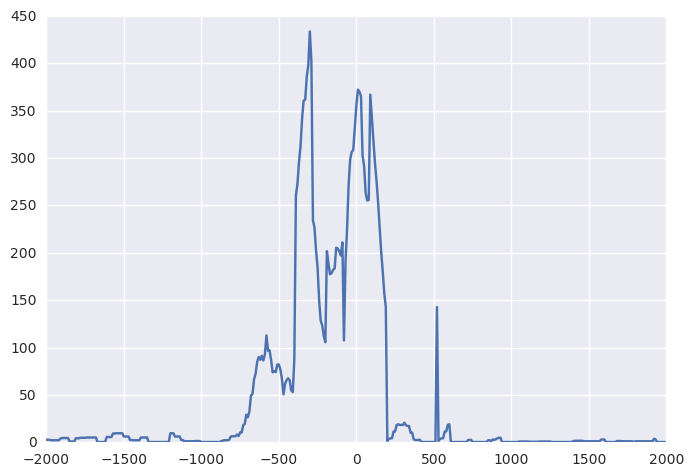

In [231]:
import pandas as pd

peak_score_w_ecd = {}

fh = open("py_peaks_w_ecd.bed","w")
ave_vals = {}
location = []
for p in peaks_ecd:
    peak_pos = pos_list[p]
    temp_str = "chr3L\t" + str(peak_pos-250) + "\t" + str(peak_pos+250) + "\t" + str(p) + "\n"
    fh.write(temp_str)
    for i in range(peak_pos-2000,peak_pos+2000):
        if i in w_ecd['3L']:
            ave_vals.setdefault('val',{})
            if i-peak_val in ave_vals:
                ave_vals['val'][i-peak_pos] += w_ecd['3L'][i]
            else:
                ave_vals['val'][i-peak_pos] = w_ecd['3L'][i]
    score=0
    key="chr3L:" + str(peak_pos-250) + "-" + str(peak_pos+250)
    for i in range(peak_pos-100,peak_pos+100):
        if i in w_ecd['3L']:
            score+=w_ecd['3L'][i]
        peak_score_w_ecd[key] = score/20

fh.close()
df_ave_vals = pd.DataFrame(ave_vals)
df_ave_vals['val'] /= len(peaks_ecd)
#df_ave_vals.head()
plt.plot(df_ave_vals)
plt.show()

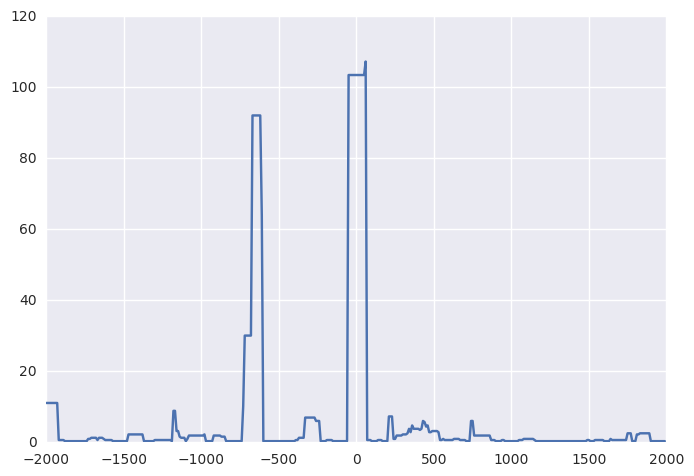

In [232]:
fh = open("py_peaks_wo_ecd.bed","w")
ave_vals_wo = {}
location_wo = []
for p in peaks_wo_ecd:
    peak_pos = pos_list_wo[p]
    temp_str = "chr3L\t" + str(peak_pos-250) + "\t" + str(peak_pos+250) + "\t" + str(p) + "\n"
    fh.write(temp_str)
    for i in range(peak_pos-2000,peak_pos+2000):
        if i in wo_ecd['3L']:
            ave_vals_wo.setdefault('val',{})
            if i-peak_val in ave_vals_wo:
                ave_vals_wo['val'][i-peak_pos] += wo_ecd['3L'][i]
            else:
                ave_vals_wo['val'][i-peak_pos]  = wo_ecd['3L'][i]

fh.close()
df_ave_vals = pd.DataFrame(ave_vals_wo)
df_ave_vals['val'] /= len(peaks_wo_ecd)
plt.plot(df_ave_vals)
plt.show()

What Transcription Factor motifs underlie enhancer peaks?

In [233]:
import pybedtools 

enhancers_w_ecd = pybedtools.BedTool('py_peaks_w_ecd.bed')
enhancers_wo_ecd = pybedtools.BedTool('py_peaks_wo_ecd.bed')

activated_enhancers = enhancers_w_ecd - enhancers_wo_ecd #Enhancers unique to Ecdysone treatment

print(activated_enhancers.count())

g = activated_enhancers.sequence(fi='3L.fa')

#g.seqfn

fo = open('w_ecd_peaks.fa', 'w')
fo.write(open(g.seqfn).read())

g = enhancers_wo_ecd.sequence(fi='3L.fa')

fo = open('wo_ecd_peaks.fa', 'w')
fo.write(open(g.seqfn).read())

177


192698

In [234]:
w_ecd_motifs = pd.read_csv('fimo_w_ecd.txt',sep='\t')
w_ecd_motifs.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MA0533.1,su(Hw),chr3L:19243340-19243840,328,348,-,24.1939,1.470000e-09,0.000243,GCACAAAAGTATGCAACAACT
1,MA0531.1,CTCF,chr3L:17153580-17154080,84,98,-,20.5000,1.610000e-08,0.002760,CCACTAGGTGGCGCT
2,MA0534.1,EcR::usp,chr3L:17972150-17972650,119,133,+,18.1053,1.370000e-07,0.008200,CAGTTCAATGAACTC
3,MA0534.1,EcR::usp,chr3L:17971920-17972420,349,363,+,18.1053,1.370000e-07,0.008200,CAGTTCAATGAACTC
4,MA0534.1,EcR::usp,chr3L:17981250-17981750,451,465,+,18.0789,1.430000e-07,0.008200,AAGTTCATTGCACTT


In [235]:
wo_ecd_motifs = pd.read_csv('fimo_wo_ecd.txt',sep='\t')
wo_ecd_motifs.head()

,# motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence
0,MA0237.2,pan,chr3L:1465540-1466040,324,337,-,18.8415,4.370000e-08,0.0155,GCGGCTTCTTTGAT
1,MA0086.2,sna,chr3L:3929910-3930410,433,445,-,17.2114,6.960000e-08,0.0249,GGGACAGGTGCAC
2,MA0197.2,nub,chr3L:11349920-11350420,440,451,-,18.4286,1.020000e-07,0.0351,TATGCAAATTAG
3,MA0533.1,su(Hw),chr3L:21359490-21359990,480,500,-,19.3163,1.540000e-07,0.0539,GCCTAGAAGTATGCAATTGCT
4,MA0535.1,Mad,chr3L:3784630-3785130,157,171,+,17.5789,2.470000e-07,0.0876,GAGGCGCCGCCGCCA


In [241]:
norm_w_ecd = (w_ecd_motifs.groupby('motif_alt_id').count()/len(w_ecd_motifs)).iloc[:,0:1]
norm_wo_ecd = (wo_ecd_motifs.groupby('motif_alt_id').count()/len(wo_ecd_motifs)).iloc[:,0:1]
#print(norm_w_ecd.head())
#print(norm_wo_ecd.head())
mergeddf = pd.merge(norm_w_ecd, norm_wo_ecd, how = 'left', on = 'motif_alt_id')
mergeddf.head()

,# motif_id_x,# motif_id_y
motif_alt_id,,
Abd-B,0.008268,0.010872
Antp,0.007516,0.008292
B-H1,0.013529,0.013820
B-H2,0.013529,0.013820
BEAF-32,0.006764,0.009766


In [242]:
ratio_w  = mergeddf['# motif_id_x']
ratio_wo = mergeddf['# motif_id_y']

Enrichment = (ratio_w / ratio_wo)
#print(Enrichment)

#Now add these values as a new column
newdf = mergeddf.assign(Enrichment = Enrichment)
print(newdf.sort_values(by='Enrichment',ascending=False).head(10))

              # motif_id_x  # motif_id_y  Enrichment
motif_alt_id                                        
br(var.3)         0.023300      0.011977    1.945330
EcR::usp          0.012777      0.007186    1.777990
twi               0.010522      0.006449    1.631567
Ptx1              0.003006      0.001843    1.631567
Stat92E           0.013153      0.008845    1.487105
h                 0.008268      0.005896    1.402128
onecut            0.023675      0.016952    1.396586
usp               0.005637      0.004054    1.390540
gt                0.004510      0.003317    1.359639
opa               0.008268      0.006081    1.359639


In [ ]:
peak_score_w_ecd[w_ecd_motifs.iloc[0]['sequence_name']]

In [243]:
with_score = pd.DataFrame()
for i in newdf.sort_values(by='Enrichment',ascending=False).head(5).index.values:
    new_df = w_ecd_motifs.query("motif_alt_id == '{0}'".format(i)).iloc[:,1:3]
    #print(new_df.head(1))
    score_col = []
    for index, row in new_df.iterrows():
        score_col.append(peak_score_w_ecd[row['sequence_name']])
    new_df = new_df.assign(score_col = score_col)
    with_score = with_score.append(new_df)
with_score.head()

,motif_alt_id,sequence_name,score_col
70,br(var.3),chr3L:16282200-16282700,50861.946927
71,br(var.3),chr3L:24574110-24574610,70076.579067
110,br(var.3),chr3L:7144460-7144960,72836.426022
124,br(var.3),chr3L:17577240-17577740,59518.559904
152,br(var.3),chr3L:8149460-8149960,41595.600321


//anaconda/lib/python3.5/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


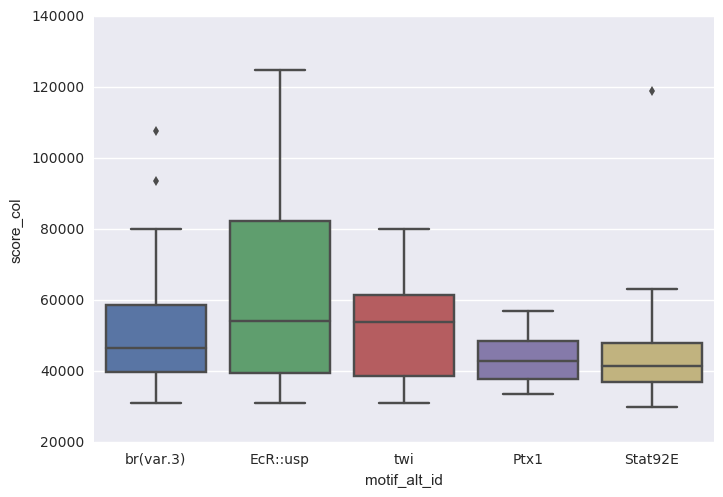

In [244]:
import seaborn as sns
sns.boxplot(data = with_score, x = 'motif_alt_id', y = 'score_col')
plt.show()